In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
import tensorflow_datasets as tfds
from imgaug import augmenters as iaa

from keras.api.keras.datasets import cifar10

tfds.disable_progress_bar()
tf.random.set_seed(42)
ia.seed(42)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

170498071/170498071 [==============================] - 8s 0us/step
Total training examples: 50000
Total test examples: 10000


In [6]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 1
IMAGE_SIZE = 72

In [68]:
rand_aug = iaa.RandAugment(n=0, m=0)


def augment(images):
    # Input to `augment()` is a TensorFlow tensor which
    # is not supported by `imgaug`. This is why we first
    # convert it to its `numpy` variant.
    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())

In [69]:
train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

In [70]:
simple_aug = tf.keras.Sequential(
    [
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

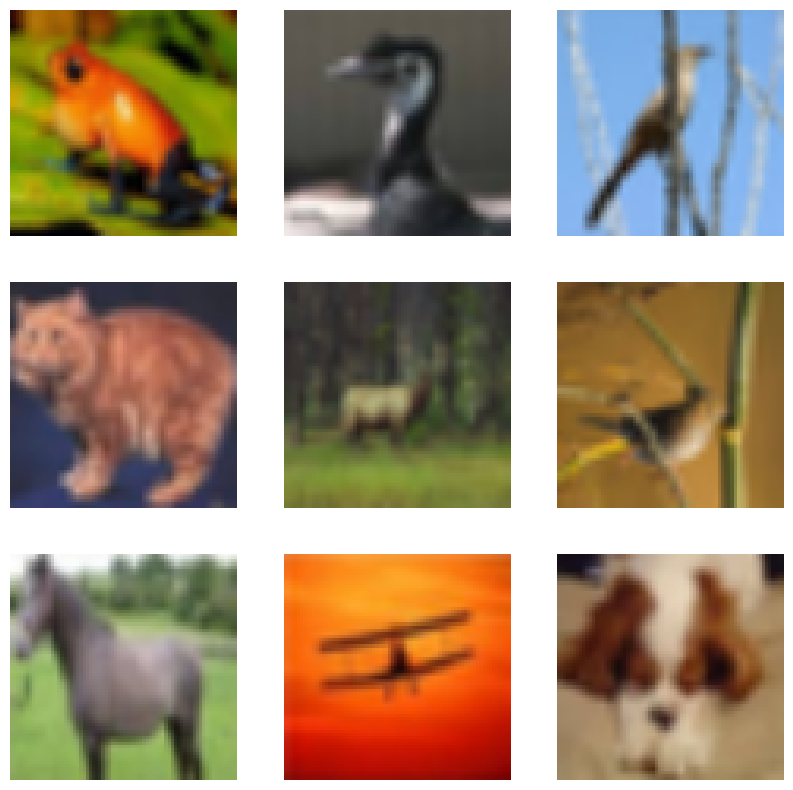

In [71]:
sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

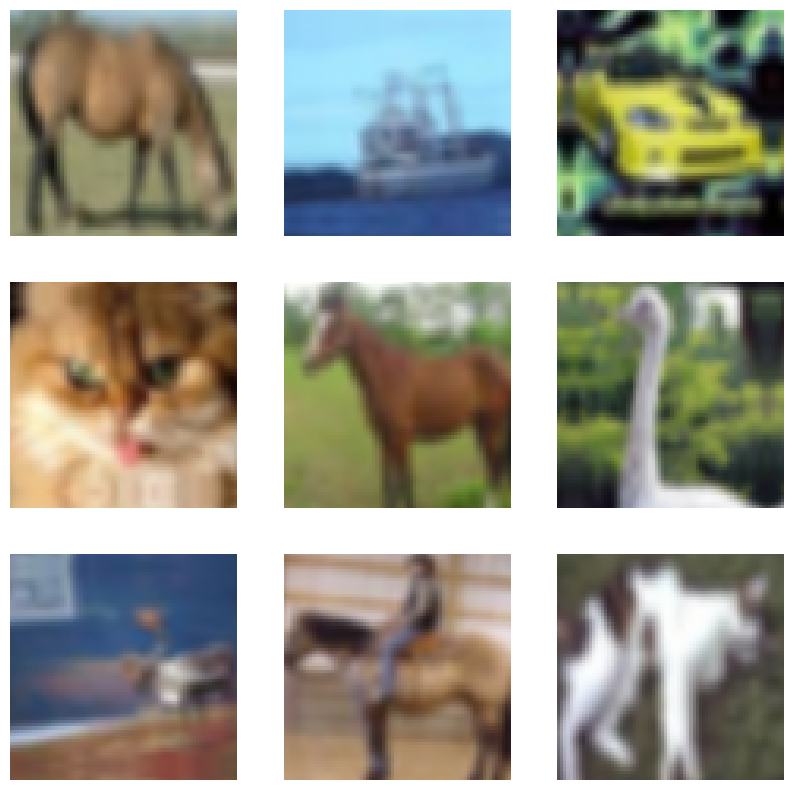

In [72]:
sample_images, _ = next(iter(train_ds_simple))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")